In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal, stats
import re
import sys
import os
import mne
import mne_connectivity
import IPython
import seaborn as sns
import scipy
import joblib
import h5io
import dask.array as da 
import itertools
from plotnine import *
import pickle
import statsmodels
from statsmodels import stats
from statsmodels.stats import multitest
import tensorpac as tp

In [2]:
## Prep paths ##

raw_data_dir = f"/home/brooke/pacman/raw_data/"
preproc_data_dir = f"/home/brooke/pacman/preprocessing/"
t7_folder = '/media/brooke/T7/pacman/connectivity/pac/data/to_ofc'

In [10]:
## Load in the electrodes with sig theta coherence
# Load sig pairs data
sg_full_df = pd.read_csv('/home/brooke/pacman/connectivity/scripts/pac/sig_theta_pairs.csv')

# Filter the DataFrame
sg_df = sg_full_df[
    (sg_full_df['roi_pair'].isin(['ofc_insula', 'ofc_amyg', 'ofc_hc', 'ofc_dlpfc', 'ofc_cing'])) &
    (sg_full_df['metric'] == 'Imaginary Coherence')
]

# Add elec1 and elec2 columns
sg_df['elec1'] = sg_df['pairs'].str.replace('_to_.*', '', regex=True)
sg_df['elec2'] = sg_df['pairs'].str.replace('.*_to_', '', regex=True)



/tmp/ipykernel_399203/423440140.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_399203/423440140.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
sg_df

,subject,pairs,roi_pair,metric,elec1,elec2
77,BJH025,A1-A2_to_B10-B11,ofc_cing,Imaginary Coherence,A1-A2,B10-B11
80,BJH025,A1-A2_to_B12-B13,ofc_dlpfc,Imaginary Coherence,A1-A2,B12-B13
83,BJH025,A1-A2_to_B13-B14,ofc_dlpfc,Imaginary Coherence,A1-A2,B13-B14
86,BJH025,A1-A2_to_B14-B15,ofc_dlpfc,Imaginary Coherence,A1-A2,B14-B15
89,BJH025,A1-A2_to_B15-B16,ofc_dlpfc,Imaginary Coherence,A1-A2,B15-B16
...,...,...,...,...,...,...
14340,LL13,LOF1-LOF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,LOF1-LOF2,RH1-RH2
14343,LL10,ROF1-ROF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,ROF1-ROF2,RH1-RH2
14346,LL12,ROF1-ROF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,ROF1-ROF2,RH1-RH2
14348,LL13,ROF1-ROF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,ROF1-ROF2,RH1-RH2


In [5]:
from_ofc_done = pd.read_csv('/home/brooke/pacman/connectivity/scripts/pac/compiled_to_ofc_results.csv')

In [8]:
from_ofc_done


,subject,elec1,elec2,test_stat,pval,pairs,roi_pair,metric
0,BJH025,A1-A2,B10-B11,0.048114,0.005,A1-A2_to_B10-B11,ofc_cing,Imaginary Coherence
1,BJH025,A1-A2,B12-B13,0.120658,0.000,A1-A2_to_B12-B13,ofc_dlpfc,Imaginary Coherence
2,BJH025,A1-A2,B13-B14,0.013097,1.000,A1-A2_to_B13-B14,ofc_dlpfc,Imaginary Coherence
3,BJH025,A1-A2,B14-B15,0.044039,0.000,A1-A2_to_B14-B15,ofc_dlpfc,Imaginary Coherence
4,BJH025,A1-A2,B15-B16,0.122112,0.000,A1-A2_to_B15-B16,ofc_dlpfc,Imaginary Coherence
...,...,...,...,...,...,...,...,...
1132,BJH039,BR9-BR10,CR8-CR9,0.184625,0.000,BR9-BR10_to_CR8-CR9,ofc_dlpfc,Imaginary Coherence
1133,BJH039,BR9-BR10,CR9-CR10,0.012003,1.000,BR9-BR10_to_CR9-CR10,ofc_dlpfc,Imaginary Coherence
1134,BJH039,BR9-BR10,DR10-DR11,0.083810,0.000,BR9-BR10_to_DR10-DR11,ofc_dlpfc,Imaginary Coherence
1135,BJH039,BR9-BR10,GR5-GR6,0.000000,1.000,BR9-BR10_to_GR5-GR6,ofc_hc,Imaginary Coherence


In [6]:
# load compelted pac analyses
from_ofc_done = pd.read_csv('/home/brooke/pacman/connectivity/scripts/pac/compiled_from_ofc_results.csv')

# Perform the anti-join
merged_df = sg_df.merge(from_ofc_done, on=['subject', 'elec1', 'elec2'], how='left', indicator=True)

# Filter the rows that are only in sg_df
remaining_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# fix and drop columns
remaining_df.drop(['test_stat', 'pval', 'pairs_y', 'roi_pair_y', 'metric_y'], axis=1, inplace=True)
rename_mapping = dict(zip(remaining_df.columns, sg_df.columns))
remaining_df.rename(columns=rename_mapping, inplace=True)

# replace sg_df with the updated version
sg_df = remaining_df

In [7]:
sg_df

,subject,pairs,roi_pair,metric,elec1,elec2
897,BJH029,D'1-D'2_to_A1-A2,ofc_amyg,Imaginary Coherence,D'1-D'2,A1-A2
898,BJH029,D'1-D'2_to_A2-A3,ofc_amyg,Imaginary Coherence,D'1-D'2,A2-A3
899,BJH029,D'1-D'2_to_G'7-G'8,ofc_insula,Imaginary Coherence,D'1-D'2,G'7-G'8
900,BJH029,D'1-D'2_to_M'11-M'12,ofc_insula,Imaginary Coherence,D'1-D'2,M'11-M'12
901,BJH029,D'2-D'3_to_A'4-A'5,ofc_amyg,Imaginary Coherence,D'2-D'3,A'4-A'5
...,...,...,...,...,...,...
1651,LL13,LOF1-LOF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,LOF1-LOF2,RH1-RH2
1652,LL10,ROF1-ROF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,ROF1-ROF2,RH1-RH2
1653,LL12,ROF1-ROF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,ROF1-ROF2,RH1-RH2
1654,LL13,ROF1-ROF2_to_RH1-RH2,ofc_hc,Imaginary Coherence,ROF1-ROF2,RH1-RH2


In [53]:
## prep pac objects
### Get the freqs for the phase, amplitude
p_freqs = tp.Pac(idpac=(2, 0, 0), f_pha='hres', f_amp='hres')
theta_phases = [x for x in p_freqs.f_pha if x[0] >= 2 and x[1] <= 9]
hfa_amps = [x for x in p_freqs.f_amp if x[0] >= 70]
### main pac object
p = tp.Pac(idpac=(2, 0, 0), f_pha=theta_phases, f_amp=hfa_amps)

Phase Amplitude Coupling object defined
Phase Amplitude Coupling object defined


In [54]:
sub = 'LL14'

# filter to current subject
sub_df = sg_df[sg_df['subject'] == sub]

In [6]:
sg_df = sg_full_df[
    (sg_full_df['roi_pair'].isin(['ofc_insula', 'ofc_amyg', 'ofc_hc', 'ofc_dlpfc', 'ofc_cing'])) &
    (sg_full_df['metric'] == 'Imaginary Coherence')
]

# Add elec1 and elec2 columns
sg_df['elec1'] = sg_df['pairs'].str.replace('_to_.*', '', regex=True)
sg_df['elec2'] = sg_df['pairs'].str.replace('.*_to_', '', regex=True)

# load compelted pac analyses
to_ofc_done = pd.read_csv('/home/brooke/pacman/connectivity/scripts/pac/compiled_to_ofc_results.csv')

# Perform the anti-join
merged_df = sg_df.merge(to_ofc_done, on=['subject', 'elec1', 'elec2'], how='left', indicator=True)

# Filter the rows that are only in sg_df
remaining_df = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])

# fix and drop columns
remaining_df.drop(['test_stat', 'pval', 'pairs_y', 'roi_pair_y', 'metric_y'], axis=1, inplace=True)
rename_mapping = dict(zip(remaining_df.columns, sg_df.columns))
remaining_df.rename(columns=rename_mapping, inplace=True)

# replace sg_df with the updated version
sg_df = remaining_df
sg_df['roi_pair'].value_counts()


/tmp/ipykernel_337211/2547318477.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/tmp/ipykernel_337211/2547318477.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


roi_pair
ofc_amyg      201
ofc_insula     47
ofc_dlpfc      32
ofc_hc         27
ofc_cing       22
Name: count, dtype: int64

In [70]:
# Get Sub list
subject_list = sg_df['subject'].unique()

# Loop over subject
# for sub in subject_list:
sub = 'LL14'

# filter to current subject
sub_df = sg_df[sg_df['subject'] == sub]

## Load Neural Data
# load
last_away_epochs = mne.read_epochs(f"{preproc_data_dir}/{sub}/ieeg/{sub}_bp_filtered_clean_last_away_events.fif")

if sub == 'LL14':
    # get good epochs (for behavioral data only) & Manually add more bad trials because of a bipolar referencing issue that created NANs
    good_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if not x and i not in [432, 433, 484, 628, 634, 635]]
    bad_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if  x or i in [432, 433, 484, 628, 634, 635]]
else:
    # get good epochs (for behavioral data only)
    good_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if not x]
    bad_epochs = [i for i,x in enumerate(last_away_epochs.get_annotations_per_epoch()) if  x]

# load behavioral data
last_away_data = pd.read_csv(f"{raw_data_dir}/{sub}/behave/{sub}_last_away_events.csv")

# set info as metadata
last_away_epochs.metadata = last_away_data

# onlt good epochs
last_away_epochs = last_away_epochs[good_epochs]

# only approach
last_away_epochs = last_away_epochs.crop(tmin=-2, tmax=0)

# downsample to 512 Hz since LL is maxed out at 512
last_away_epochs = last_away_epochs.resample(512)

# Get the ofc elec list
ofc_list = sub_df['elec1'].unique()

# Loop over ofc elecs
# for ofc_elec in ofc_list:
ofc_elec = 'LOF1-LOF2'

# filter to current ofc elec
ofc_elec_df = sub_df[sub_df['elec1'] == ofc_elec]

# prep ofc elec
ofc_data = last_away_epochs.copy().pick([ofc_elec])
ofc_array = np.squeeze(ofc_data.get_data())

# get the amplitudes
phases = p.filter(last_away_epochs.info['sfreq'], ofc_array, ftype='phase', n_jobs = 16)

# get ofc elec pairs
ofc_pairs_list = ofc_elec_df['elec2'].unique()

# loop over the other elecs
for roi_pair in ofc_pairs_list:

    # prep roi pair
    roi_data = last_away_epochs.copy().pick([roi_pair])
    roi_array = np.squeeze(roi_data.get_data())

    # get the phases
    amplitudes = p.filter(last_away_epochs.info['sfreq'], roi_array, ftype='amplitude', n_jobs = 16)

    # get the pac
    p.idpac = (2, 3, 4)
    xpac = p.fit(phases, amplitudes, n_perm=200, n_jobs = 16, mcp = 'fdr')

    # # Save the object to a file
    # with open(f'{t7_folder}/{sub}_{ofc_elec}_{roi_pair}_pac.pkl', 'wb') as file:
    #     pickle.dump(p, file)

Reading /home/brooke/pacman/preprocessing/LL14/ieeg/LL14_bp_filtered_clean_last_away_events.fif ...


/tmp/ipykernel_309766/3205637420.py:13: RuntimeWarning: This filename (/home/brooke/pacman/preprocessing//LL14/ieeg/LL14_bp_filtered_clean_last_away_events.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz


    Found the data of interest:
        t =   -5000.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
729 matching events found
No baseline correction applied
0 projection items activated
Adding metadata with 5 columns
Sampling frequency of the instance is already 512.0, returning unmodified.


/tmp/ipykernel_309766/3205637420.py:51: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
/tmp/ipykernel_309766/3205637420.py:64: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
    true PAC estimation using Modulation Index (MI, Tort et al. 2010)
    compute surrogates (Time lag (Canolty et al. 2006), 200 permutations, random_state=6172)


KeyboardInterrupt: 

In [65]:
ofc_array.shape

(593, 1025)

In [69]:
np.isnan(phases).any()

True

In [62]:
p.idpac = (2, 3, 4)
xpac = p.fit(phases, amplitudes, n_perm=200, n_jobs = 16, mcp = 'fdr')

AssertionError: Your phase is probably in degrees and should be converted in radians using either np.degrees or np.deg2rad.

In [27]:
with open(f'{t7_folder}/BJH027_AL1-AL2_BL15-BL16_pac.pkl', 'rb') as f:
    p1 = pickle.load(f)


with open(f'{t7_folder}/BJH027_AL1-AL2_GL7-GL8_pac.pkl', 'rb') as f:
    p2 = pickle.load(f)

In [35]:
p2.pac[20, 3, :].mean()

0.009158179455635764

### TO OFC

In [19]:
t7_folder = '/media/brooke/T7/pacman/connectivity/pac/data/to_ofc'
all_files = os.listdir(t7_folder)
pac_files= list(filter(lambda s: '_to_' in s, all_files))
bj16_files = list(filter(lambda s: 'BJH016' in s, pac_files))

In [20]:
for file in pac_files:
    with open(f'{t7_folder}/{file}', 'rb') as f:
        p = pickle.load(f)

    tmp = p.pvalues != 1
    if tmp.any():
        print(file)
        print(np.unique(p.pvalues, return_counts = True))

### From OFC

In [73]:
t7_folder = '/media/brooke/T7/pacman/connectivity/pac/data/from_ofc'
all_files = os.listdir(t7_folder)
pac_files= list(filter(lambda s: '_to_' in s, all_files))
bj16_files = list(filter(lambda s: 'BJH016' in s, pac_files))

In [74]:
for file in bj16_files:
    with open(f'{t7_folder}/{file}', 'rb') as f:
        p = pickle.load(f)

    test_stat, pval, cluster= find_pair_pac_pvalue(p)
    print(f"file: {file}, test stat: {test_stat}, pval: {pval}")


file: BJH016_AL1-AL2_to_BL11-BL12_pac.pkl, test stat: 0.042758906518651094, pval: 1
file: BJH016_AL1-AL2_to_BL12-BL13_pac.pkl, test stat: 0.023332546924956326, pval: 1
file: BJH016_AL1-AL2_to_BL13-BL14_pac.pkl, test stat: 0.058888293103942654, pval: 0.005
file: BJH016_AL1-AL2_to_BL14-BL15_pac.pkl, test stat: 0.0, pval: 1


KeyboardInterrupt: 

In [28]:
file
with open(f'{t7_folder}/{file}', 'rb') as f:
    p = pickle.load(f)

average_perm_pac = p.surrogates.mean(-1)
average_pac = p.pac.mean(-1)

# find the uncorrected p values
tmp = average_pac <= average_perm_pac
uncorrected_p = np.sum(tmp, axis = 0)/200

# create a mask of largest sig cluster
mask = uncorrected_p.copy()
mask[uncorrected_p > .01] = 0
mask[uncorrected_p <= .01] = 1
large_cluster = find_largest_cluster_mask(mask)   
np.sum(large_cluster) >= 10 

False

In [76]:
cluster.shape

(40, 13)

In [26]:
from scipy.ndimage import label

def find_largest_cluster_mask(matrix):

    if not matrix.any():
        return matrix
    
    # Label the connected components in the inverted matrix
    labeled_array, num_features = label(matrix)
    
    # Find the size of each connected component
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Exclude the background component (label 0)
    largest_component_label = component_sizes[1:].argmax() + 1
    
    # Create a mask for the largest component
    largest_cluster_mask = (labeled_array == largest_component_label).astype(int)
    
    return largest_cluster_mask

In [29]:
def find_pair_pac_pvalue(p):

    # create average pac and average perm pac by averaging over trials
    average_perm_pac = p.surrogates.mean(-1)
    average_pac = p.pac.mean(-1)

    # find the uncorrected p values
    tmp = average_pac <= average_perm_pac
    uncorrected_p = np.sum(tmp, axis = 0)/200

    # create a mask of largest sig cluster
    mask = uncorrected_p.copy()
    mask[uncorrected_p > .01] = 0
    mask[uncorrected_p <= .01] = 1
    large_cluster = find_largest_cluster_mask(mask)

    if np.sum(large_cluster) >= 5:

        # sum pac values in the largest cluster for each surrogate
        perm_test_stat = np.zeros((200, 1))
        for i in range(200):
            tmp = average_perm_pac[i, :, :]
            tmp[large_cluster == 0] = 0
            perm_test_stat[i] = np.sum(tmp)  

        # get summed pac value of the real data
        real_pac = average_pac.copy()
        real_pac[large_cluster == 0] = 0
        test_stat = np.sum(real_pac) 

        # get the p value
        pval = np.sum(test_stat <= perm_test_stat)/200
    else:
        # get summed pac value of the real data
        real_pac = average_pac.copy()
        real_pac[large_cluster == 0] = 0
        test_stat = np.sum(real_pac) 
        pval = 1        


    return test_stat, pval, large_cluster

In [15]:
def find_pair_pac_pvalue_3(p):

    # create average pac and average perm pac by averaging over trials
    average_perm_pac = p.surrogates.mean(-1)
    average_pac = p.pac.mean(-1)

    # find the uncorrected p values
    tmp = average_pac <= average_perm_pac
    uncorrected_p = np.sum(tmp, axis = 0)/200

    # create a mask of largest sig cluster
    mask = uncorrected_p.copy()
    mask[uncorrected_p > .01] = 0
    mask[uncorrected_p <= .01] = 1
    large_cluster = find_largest_cluster_mask(mask)


    # sum pac values in the largest cluster for each surrogate
    perm_test_stat = np.zeros((200, 1))
    for i in range(200):
        tmp = average_perm_pac[i, :, :]
        tmp[large_cluster == 0] = 0
        perm_test_stat[i] = np.sum(tmp)  

    # get summed pac value of the real data
    real_pac = average_pac.copy()
    real_pac[large_cluster == 0] = 0
    test_stat = np.sum(real_pac) 

    # get the p value
    pval = np.sum(test_stat <= perm_test_stat)/200


    return test_stat, pval, large_cluster

In [3]:
def find_pair_pac_pvalue_2(p):

    # create average pac and average perm pac by averaging over trials
    average_perm_pac = p.surrogates.mean(-1)
    average_pac = p.pac.mean(-1)

    # sum pac values in the largest cluster for each surrogate
    perm_test_stat = np.zeros((200, 1))
    for i in range(200):
        tmp = average_perm_pac[i, :, :]
        perm_test_stat[i] = np.sum(tmp)  

    # get summed pac value of the real data
    test_stat = np.sum(average_pac) 

    # get the p value
    pval = np.sum(test_stat <= perm_test_stat)/200

    return test_stat, pval

In [30]:
# file = 'SLCH002_B4-B5_to_E2-E3_pac.pkl'
file = 'BJH016_AL1-AL2_to_BL11-BL12_pac.pkl'
with open(f'{t7_folder}/{file}', 'rb') as f:
    p = pickle.load(f)

    average_perm_pac = p.surrogates.mean(-1)
    average_pac = p.pac.mean(-1)

    # find the uncorrected p values
    tmp = average_pac <= average_perm_pac
    uncorrected_p = np.sum(tmp, axis = 0)/200

In [31]:
from statsmodels.stats.multitest import multipletests
corrected_pvals = multipletests(uncorrected_p.ravel(), alpha=0.05, method='fdr_bh')[1]
tmp = corrected_pvals <= .05
np.unique(tmp, return_counts = True)

(array([False]), array([520]))

<Axes: title={'center': 'SLCH002_B4-B5_to_E2-E3_pac.pkl'}, xlabel='Frequency for phase (hz)', ylabel='Frequency for amplitude (hz)'>

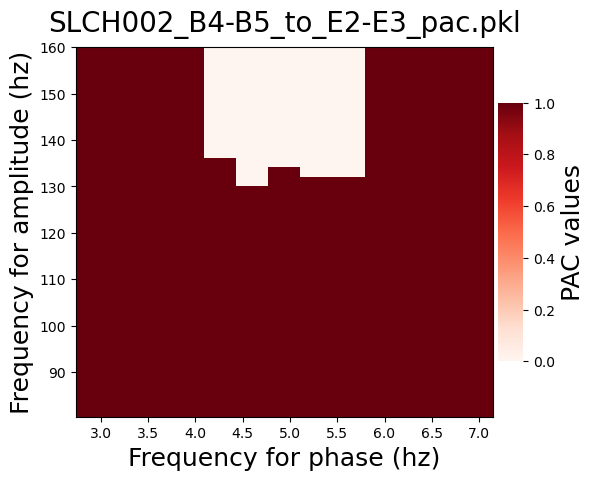

In [50]:
sig_values = np.ones_like(uncorrected_p)
sig_values[large_cluster == 1] = 0

p.comodulogram(sig_values, title = file, cmap='Reds', vmin=0,
                    fz_labels=18, fz_title=20, fz_cblabel=18)

<Axes: title={'center': 'SLCH002_B4-B5_to_E2-E3_pac.pkl'}, xlabel='Frequency for phase (hz)', ylabel='Frequency for amplitude (hz)'>

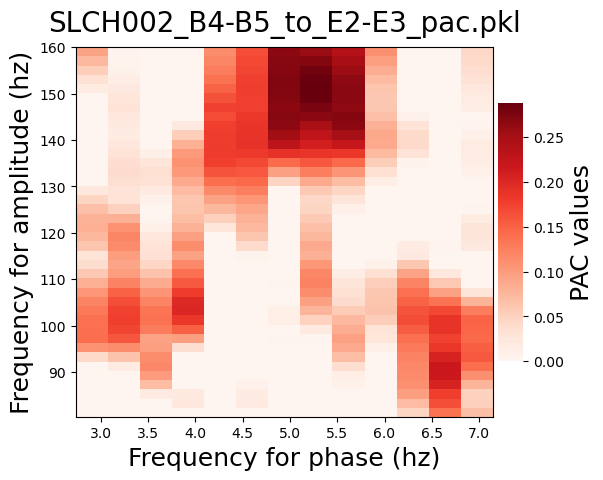

In [29]:
xpac = (p.pac - p.surrogates.mean(axis = 0)) / np.std(p.surrogates, axis = 0)
p.comodulogram(xpac.mean(-1), title = file, cmap='Reds', vmin=0,
                    fz_labels=18, fz_title=20, fz_cblabel=18)

In [22]:
sig_values[uncorrected_p > .05] = 0

(61,)

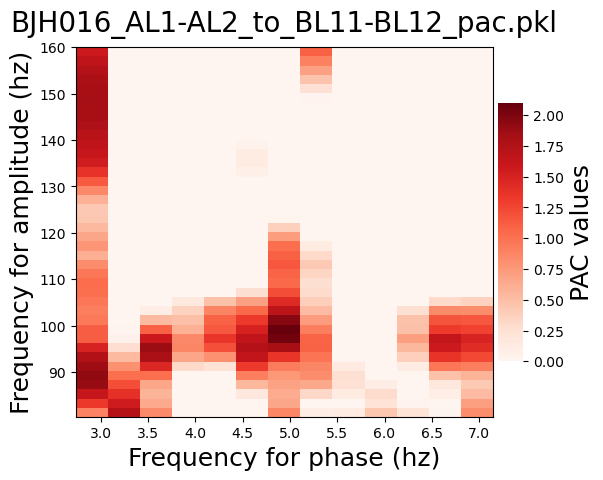

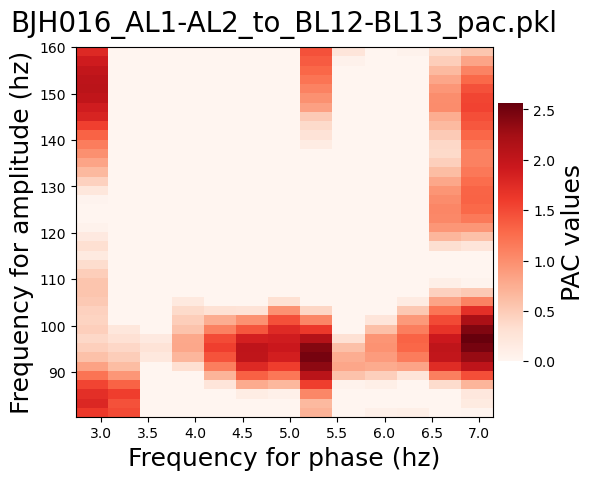

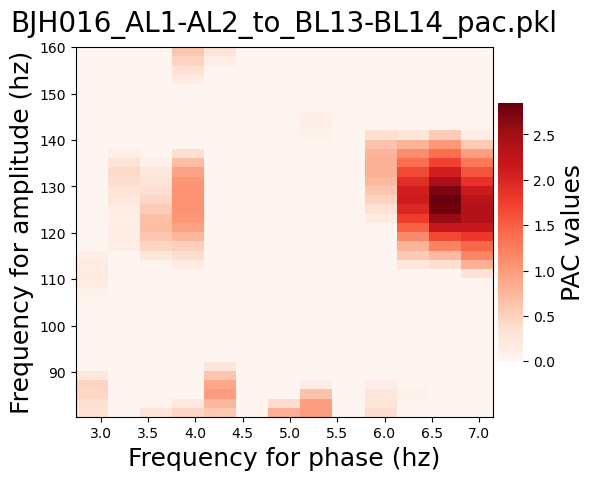

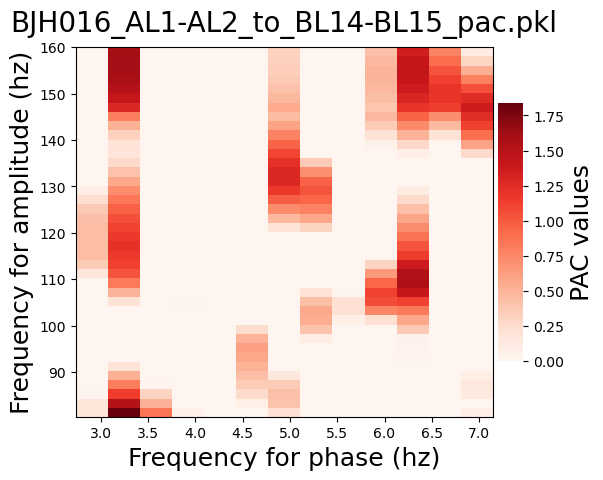

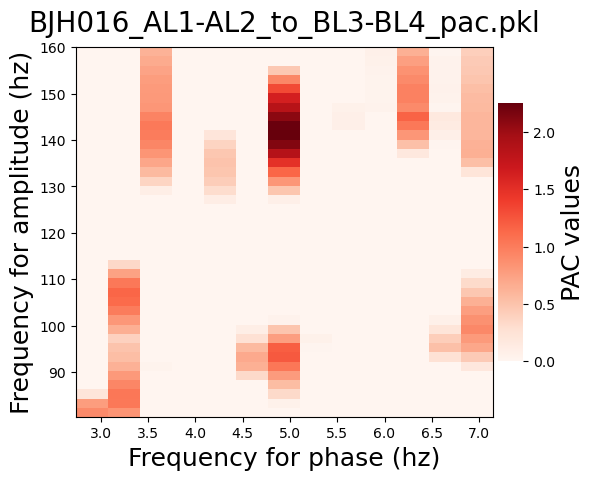

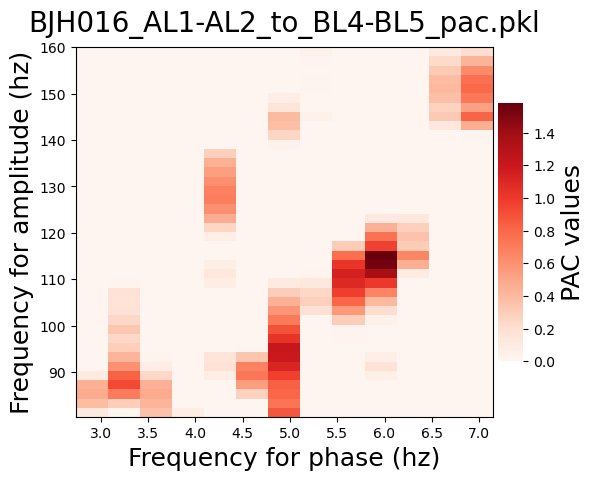

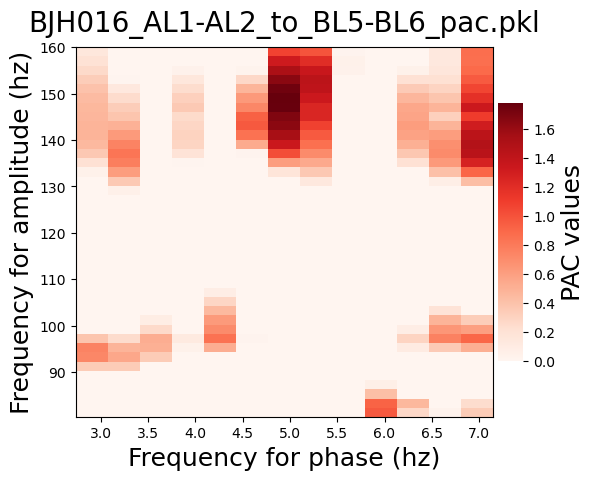

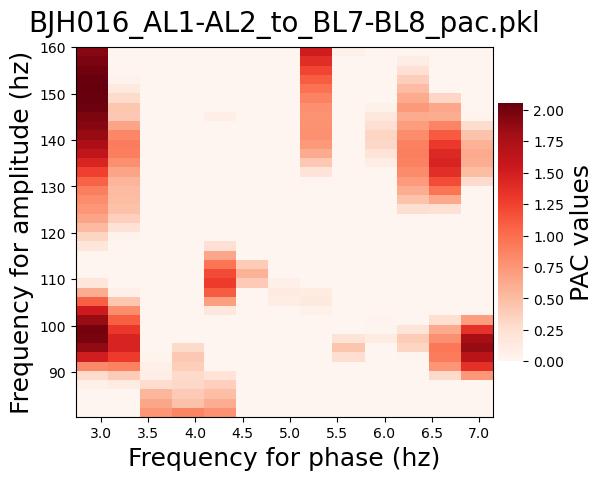

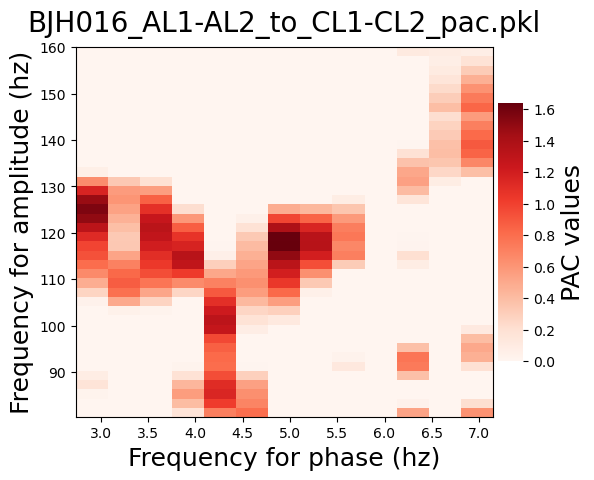

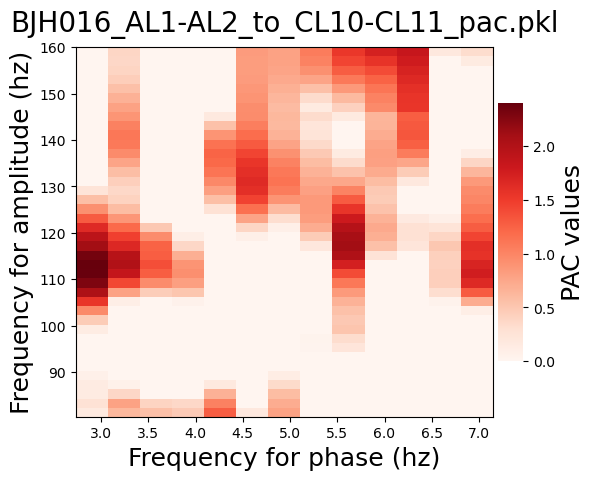

In [18]:
# pac_files = [f for f in os.listdir(t7_folder)] 

for file in bj16_files[0:10]:
    with open(f'{t7_folder}/{file}', 'rb') as f:
        p = pickle.load(f)

    xpac = p.pac.mean(-1)
    xpac_perm = p.surrogates.mean(-1)
    xpac_z = (xpac - xpac_perm.mean(axis = 0)) / np.std(xpac_perm, axis = 0)

    # tmp = p.pvalues == 1
    # print(np.unique(tmp, return_counts = True))

    p.comodulogram(xpac_z, title = file, cmap='Reds', vmin=0,
                    fz_labels=18, fz_title=20, fz_cblabel=18)
    p.show()

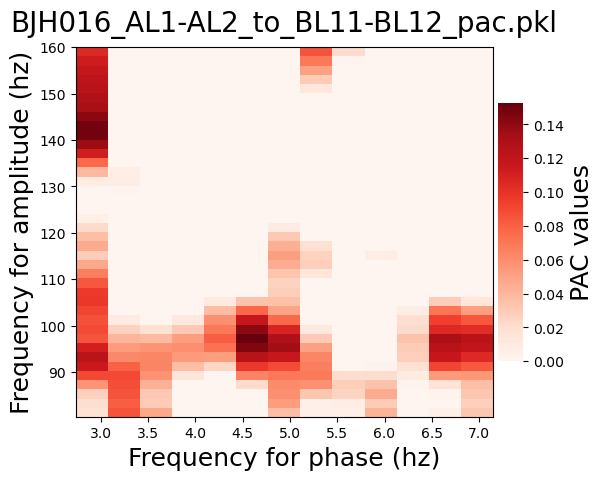

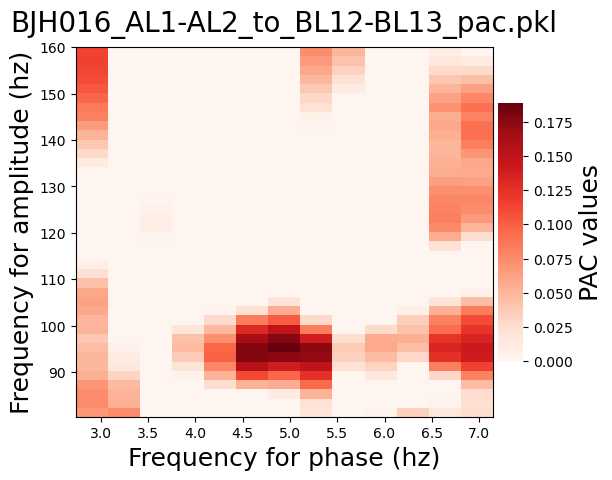

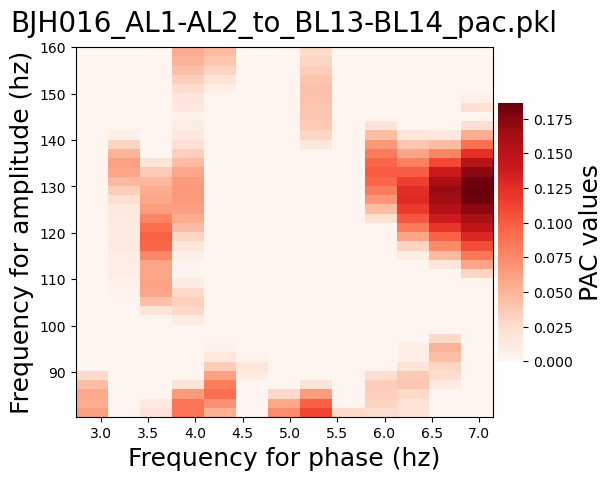

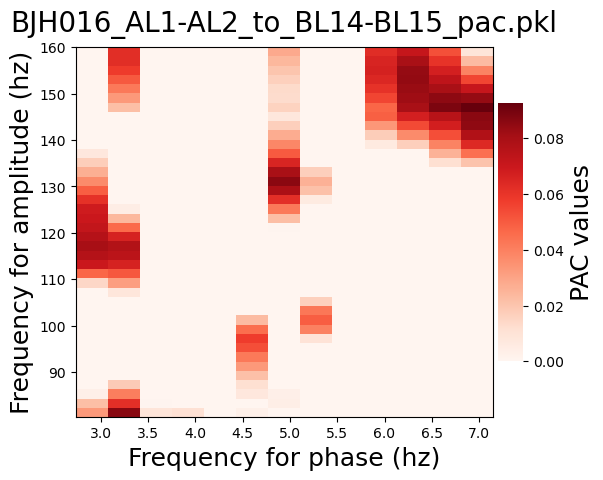

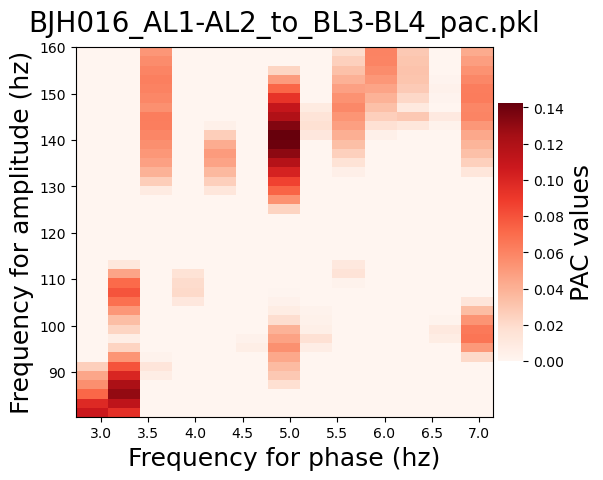

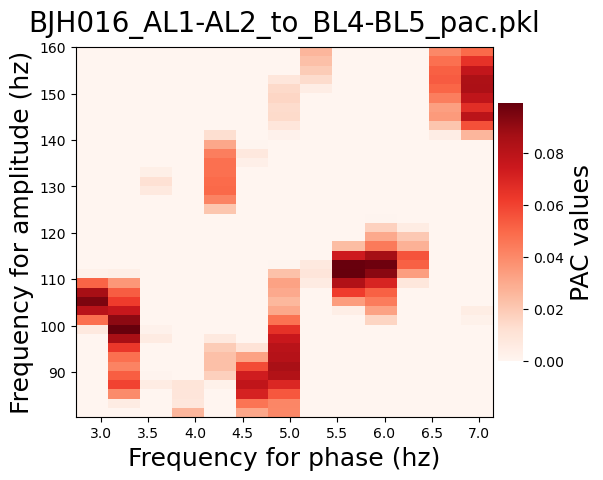

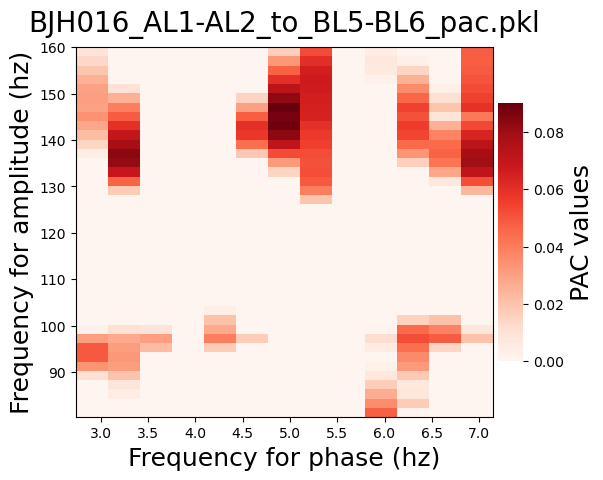

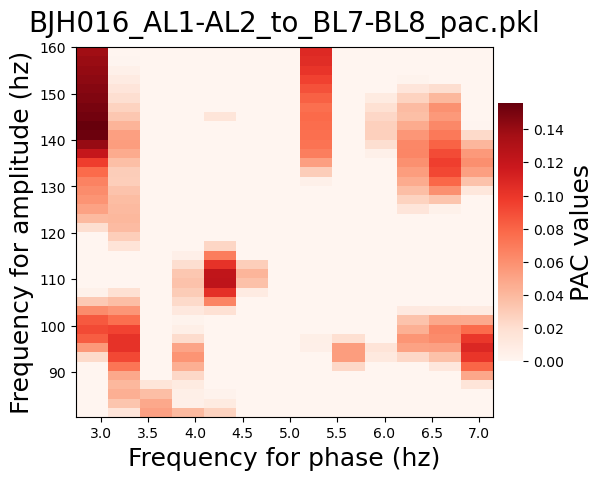

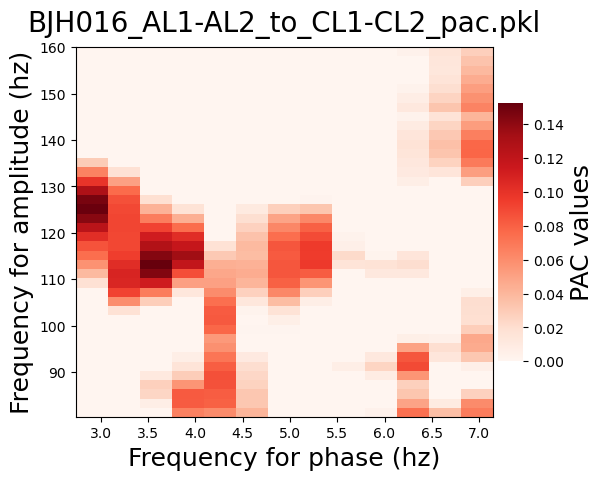

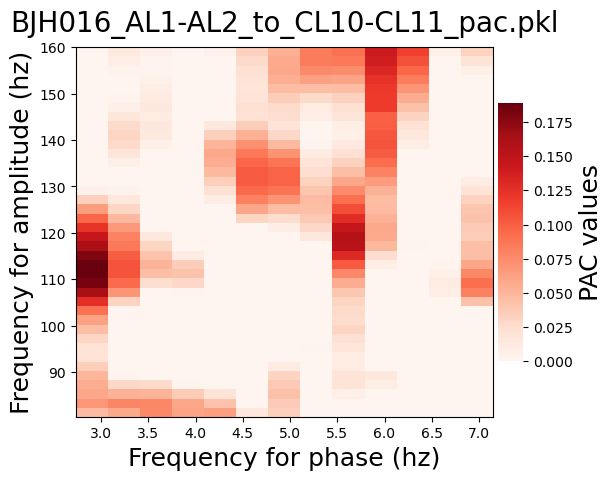

In [59]:
# pac_files = [f for f in os.listdir(t7_folder)] 

for file in bj16_files[0:10]:
    with open(f'{t7_folder}/{file}', 'rb') as f:
        p = pickle.load(f)

    xpac = (p.pac - p.surrogates.mean(axis = 0)) / np.std(p.surrogates, axis = 0)

    # tmp = p.pvalues == 1
    # print(np.unique(tmp, return_counts = True))

    p.comodulogram(xpac.mean(-1), title = file, cmap='Reds', vmin=0,
                    fz_labels=18, fz_title=20, fz_cblabel=18)
    p.show()